# Multi Layer Perceptron Model

- BOOK: [Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/) by Jason Brownlee
- NOTES: [TS -> ML split function](https://detraviousjbrinkley.notion.site/TS-ML-split-function-9ab51cbb49d244aa8b4ab434d009f8a7?pvs=4) by Detravious J.B. 
    - See for Forecast vs Prediction

In [1]:
import os
import sys
import torch

import numpy as np
import pandas as pd

import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../framework_for_time_series_data/tslearn/'))
from ml_models import MLP
from ts_models import EvaluationMetric

In [2]:
observations = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Book's implementation

In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out): 
    X, y = list(), list() 
    for i in range(len(sequence)): 
        # find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        # check if we are beyond the sequence 
        if out_end_ix > len(sequence): 
            break
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
X, y = split_sequence(observations, 3, 3)

In [5]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [6]:
y

array([[40, 50, 60],
       [50, 60, 70],
       [60, 70, 80],
       [70, 80, 90]])

# My implementation

In [7]:
def convert_uts_sequence_to_sml(uts_observations, prior_observations, forecasting_step):
    """Splits a given UTS into multiple input rows where each input row has a specified number of timestamps and the output is a single timestamp.
    
    Parameters:
    uts_observations -- 1D np array (of UTS data to transform to SML data with size  b rows/length x 1 dimension)
    prior_observations -- py int (of all observations before we get to where we want to start making the predictions)
    forecasting_step -- py int (of how far out to forecast, 1 only the next timestamp, 2 the next two timestamps, ... n the next n timestamps)
    
    Return:
    agg.values -- np array (of new sml data)
    """
    
    df = pd.DataFrame(uts_observations)
    cols = list()
    
    lag_col_names = []
    count_lag = 0
    # input sequence (t-n, ... t-1)
    for prior_observation in range(prior_observations, 0, -1):
        # print("prior_observation: ", prior_observation)
        cols.append(df.shift(prior_observation))
        new_col_name = "t - " + str(prior_observation)
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecasting_step):
        cols.append(df.shift(-i))
        # print(f"t + {i}")
        if i == 0:
            new_col_name = f"t"
        else:
            new_col_name = f"t + {i}"
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
        # put it all together
        uts_sml_df = pd.concat(cols, axis=1) 
        uts_sml_df.columns=[lag_col_names]
        # drop rows with NaN values
        uts_sml_df.dropna(inplace=True)
    
    # print(uts_sml_df)
    
    # colums to use to make prediction for last col
    X_train = uts_sml_df.iloc[:, 0: -1]
    
    # last column
    y_train = uts_sml_df.iloc[:, [-1]]
    return uts_sml_df

In [8]:
n_steps = 3
output_size = 2
converted_seq_df = convert_uts_sequence_to_sml(observations, n_steps, output_size)

In [9]:
converted_seq_df

,t - 3,t - 2,t - 1,t,t + 1
3,10.0,20.0,30.0,40,50.0
4,20.0,30.0,40.0,50,60.0
5,30.0,40.0,50.0,60,70.0
6,40.0,50.0,60.0,70,80.0
7,50.0,60.0,70.0,80,90.0


In [10]:
forecast_X_train_df = converted_seq_df.iloc[:, :n_steps]
forecast_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0
7,50.0,60.0,70.0


In [11]:
forecast_y_train_df = converted_seq_df.iloc[:, -output_size:]
forecast_y_train_df

,t,t + 1
3,40,50.0
4,50,60.0
5,60,70.0
6,70,80.0
7,80,90.0


In [12]:
forecast_X_test_df = converted_seq_df.iloc[[-1], -n_steps:]
forecast_X_test_df

,t - 1,t,t + 1
7,70.0,80,90.0


In [13]:
predict_X_train_df = converted_seq_df.iloc[:-1, :n_steps]
predict_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0


In [14]:
predict_y_train_df = converted_seq_df.iloc[:-1, -output_size:]
predict_y_train_df

,t,t + 1
3,40,50.0
4,50,60.0
5,60,70.0
6,70,80.0


In [15]:
predict_X_test_df = converted_seq_df.iloc[[-n_steps], -n_steps:]
predict_X_test_df

,t - 1,t,t + 1
5,50.0,60,70.0


In [16]:
predict_y_test_df = converted_seq_df.iloc[[-1], -output_size:]
predict_y_test_df

,t,t + 1
7,80,90.0


# Book's implementation
- Keras

## Forecast model

In [17]:
from keras.models import Sequential 
from keras.layers import Dense

forecast_model = Sequential() 
forecast_model.add(Dense(100, activation='relu' , input_dim=n_steps)) 
forecast_model.add(Dense(output_size)) 
forecast_model.compile(optimizer='adam' , loss='mse') 

predict_model = Sequential() 
predict_model.add(Dense(100, activation='relu' , input_dim=n_steps)) 
predict_model.add(Dense(output_size)) 
predict_model.compile(optimizer='adam' , loss='mse') 

2024-06-30 07:15:03.399734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 07:15:08.501692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# fit model 
forecast_model.fit(forecast_X_train_df, forecast_y_train_df, epochs=2000, verbose=0)

In [19]:
forecast_X_test = np.array(forecast_X_test_df)
forecast_X_test, forecast_X_test.shape[0]

(array([[70., 80., 90.]]), 1)

In [20]:
X_test = forecast_X_test.reshape((forecast_X_test.shape[0]), n_steps)
X_test

array([[70., 80., 90.]])

In [21]:
forecasts = forecast_model.predict(X_test, verbose=0)
forecasts

array([[102.74658 , 116.401215]], dtype=float32)

## Predict model

In [22]:
predict_model.fit(predict_X_train_df, predict_y_train_df, epochs=20, verbose=0)

In [23]:
predict_X_test = np.array(predict_X_test_df)
predict_X_test, predict_X_test.shape[0]

(array([[50., 60., 70.]]), 1)

In [24]:
predict_X_test = forecast_X_test.reshape((predict_X_test.shape[0]), n_steps)
predict_X_test

array([[70., 80., 90.]])

In [25]:
book_model_predictions = predict_model.predict(predict_X_test, verbose=0)
book_model_predictions

array([[73.85715, 67.28449]], dtype=float32)

In [26]:
predict_y_test_df

,t,t + 1
7,80,90.0


In [27]:
EvaluationMetric.eval_mse(predict_y_test_df, book_model_predictions, False)

Test MSE: 276.864


## My implementation

- Using my TSLearn library

### Prediction model

- Interpolation of in sample values 
- Use `50, 60, 70`, so X_test
- True predictions `80, 90`, so y_test

### Forecast model

- Extrapolation of future values `
- Use `70, 80, 90`, so X_test
- Expected `100, 110`. We say expected because we don't know the actual values, thus no y_test. Expected as in we increment by 10.

In [28]:
hidden_size = 100

mlp_predict_model = MLP(n_steps, hidden_size, output_size)
mlp_predict_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [29]:
mlp_forecast_model = MLP(n_steps, hidden_size, output_size)
mlp_forecast_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [30]:
# #times to loop through the training
# Hyperparameter
epochs = 2000
criterion = nn.MSELoss()

predict_optimizer = torch.optim.Adam(mlp_predict_model.parameters())
predict_configs = [criterion, predict_optimizer]

forecast_optimizer = torch.optim.Adam(mlp_forecast_model.parameters())
forecast_configs = [criterion, forecast_optimizer]

# Track different setups (ie: lr, etc) to compare this experiment to future experiments
epoch_count = []
train_pred_values = []
test_pred_values = []

predict_train_loss_values = []
predict_test_loss_values = []

forecast_train_loss_values = []
forecast_test_loss_values = []

### Training
# 0. Loop through the training
for epoch in tqdm(range(epochs)):

    # In-Sample Prediction
    train_predictions, predict_train_loss = mlp_predict_model.train_model(predict_X_train_df, predict_y_train_df, predict_configs)
    test_predictions, predict_test_loss = mlp_predict_model.interpolate_predictions(predict_X_test_df, predict_y_test_df, predict_configs)
    
    # Out-Sample Forecasts
    train_forecasts, forecast_train_loss = mlp_forecast_model.train_model(forecast_X_train_df, forecast_y_train_df, forecast_configs)
    test_forecasts = mlp_forecast_model.extrapolate_forecasts(forecast_X_test_df)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        print(f"Epoch: {epoch}")

        print(f"    Predictions | Train loss: {predict_train_loss} | Test loss: {predict_test_loss}")
        # print(f"    Predictions Parameters: {mlp_predict_model.state_dict()}")
        predict_train_loss_values.append(predict_train_loss)
        predict_test_loss_values.append(predict_test_loss)

        print(f"    Forecasts | Train loss: {forecast_train_loss}")
        # print(f"    Forecasts Parameters: {mlp_forecast_model.state_dict()}")
        forecast_train_loss_values.append(forecast_train_loss)
        # print()

  2%|▏         | 40/2000 [00:00<00:24, 80.31it/s]

Epoch: 0
    Predictions | Train loss: 4082.568603515625 | Test loss: 7801.7333984375
    Forecasts | Train loss: 5153.3154296875
Epoch: 10
    Predictions | Train loss: 2974.27197265625 | Test loss: 5335.6865234375
    Forecasts | Train loss: 3435.11328125
Epoch: 20
    Predictions | Train loss: 2056.011962890625 | Test loss: 3369.5048828125
    Forecasts | Train loss: 2098.327392578125
Epoch: 30
    Predictions | Train loss: 1311.88232421875 | Test loss: 1862.939208984375
    Forecasts | Train loss: 1133.962158203125
Epoch: 40
    Predictions | Train loss: 745.1611938476562 | Test loss: 809.2156982421875
    Forecasts | Train loss: 518.3023681640625
Epoch: 50
    Predictions | Train loss: 362.3883361816406 | Test loss: 212.43104553222656
    Forecasts | Train loss: 200.57962036132812
Epoch: 60
    Predictions | Train loss: 150.69720458984375 | Test loss: 6.719475746154785
    Forecasts | Train loss: 88.98686981201172
Epoch: 70
    Predictions | Train loss: 66.50759887695312 | Test lo

  8%|▊         | 161/2000 [00:00<00:07, 261.53it/s]

Epoch: 80
    Predictions | Train loss: 48.4417839050293 | Test loss: 146.49859619140625
    Forecasts | Train loss: 72.62535858154297
Epoch: 90
    Predictions | Train loss: 48.60411071777344 | Test loss: 205.83245849609375
    Forecasts | Train loss: 69.62776184082031
Epoch: 100
    Predictions | Train loss: 48.51105880737305 | Test loss: 208.72576904296875
    Forecasts | Train loss: 65.83531951904297
Epoch: 110
    Predictions | Train loss: 47.21466064453125 | Test loss: 186.72190856933594
    Forecasts | Train loss: 63.14654541015625
Epoch: 120
    Predictions | Train loss: 46.266109466552734 | Test loss: 165.19309997558594
    Forecasts | Train loss: 61.189735412597656
Epoch: 130
    Predictions | Train loss: 45.7205696105957 | Test loss: 152.63827514648438
    Forecasts | Train loss: 59.23064422607422
Epoch: 140
    Predictions | Train loss: 45.238189697265625 | Test loss: 148.05322265625
    Forecasts | Train loss: 57.2569694519043
Epoch: 150
    Predictions | Train loss: 44.72

 12%|█▏        | 241/2000 [00:01<00:05, 325.53it/s]

Epoch: 170
    Predictions | Train loss: 43.6480712890625 | Test loss: 147.90673828125
    Forecasts | Train loss: 51.1898193359375
Epoch: 180
    Predictions | Train loss: 43.093868255615234 | Test loss: 146.54019165039062
    Forecasts | Train loss: 49.116859436035156
Epoch: 190
    Predictions | Train loss: 42.524898529052734 | Test loss: 144.54002380371094
    Forecasts | Train loss: 47.033958435058594
Epoch: 200
    Predictions | Train loss: 41.941219329833984 | Test loss: 142.39541625976562
    Forecasts | Train loss: 44.95040512084961
Epoch: 210
    Predictions | Train loss: 41.331485748291016 | Test loss: 140.33963012695312
    Forecasts | Train loss: 42.9213752746582
Epoch: 220
    Predictions | Train loss: 40.69643783569336 | Test loss: 138.36770629882812
    Forecasts | Train loss: 40.945281982421875
Epoch: 230
    Predictions | Train loss: 40.0355224609375 | Test loss: 136.391357421875
    Forecasts | Train loss: 38.98823547363281
Epoch: 240
    Predictions | Train loss: 39

 16%|█▌        | 321/2000 [00:01<00:04, 358.02it/s]

Epoch: 260
    Predictions | Train loss: 37.871421813964844 | Test loss: 129.97268676757812
    Forecasts | Train loss: 33.35222625732422
Epoch: 270
    Predictions | Train loss: 37.076683044433594 | Test loss: 127.66363525390625
    Forecasts | Train loss: 31.54109764099121
Epoch: 280
    Predictions | Train loss: 36.23834228515625 | Test loss: 125.27082824707031
    Forecasts | Train loss: 29.793121337890625
Epoch: 290
    Predictions | Train loss: 35.36841583251953 | Test loss: 122.7021484375
    Forecasts | Train loss: 28.065942764282227
Epoch: 300
    Predictions | Train loss: 34.453521728515625 | Test loss: 119.81637573242188
    Forecasts | Train loss: 26.390514373779297
Epoch: 310
    Predictions | Train loss: 33.517822265625 | Test loss: 116.63575744628906
    Forecasts | Train loss: 24.772232055664062
Epoch: 320
    Predictions | Train loss: 32.70011901855469 | Test loss: 113.15094757080078
    Forecasts | Train loss: 23.19695281982422
Epoch: 330
    Predictions | Train loss:

 20%|██        | 402/2000 [00:01<00:04, 381.27it/s]

Epoch: 350
    Predictions | Train loss: 30.228408813476562 | Test loss: 104.3765869140625
    Forecasts | Train loss: 18.79545783996582
Epoch: 360
    Predictions | Train loss: 29.402751922607422 | Test loss: 102.03355407714844
    Forecasts | Train loss: 17.435712814331055
Epoch: 370
    Predictions | Train loss: 28.57728385925293 | Test loss: 99.66683959960938
    Forecasts | Train loss: 16.143936157226562
Epoch: 380
    Predictions | Train loss: 27.752347946166992 | Test loss: 97.28398895263672
    Forecasts | Train loss: 14.893930435180664
Epoch: 390
    Predictions | Train loss: 26.928508758544922 | Test loss: 94.94396209716797
    Forecasts | Train loss: 13.7139253616333
Epoch: 400
    Predictions | Train loss: 26.106124877929688 | Test loss: 92.672119140625
    Forecasts | Train loss: 12.591259956359863
Epoch: 410
    Predictions | Train loss: 25.287124633789062 | Test loss: 90.45851135253906
    Forecasts | Train loss: 11.525552749633789
Epoch: 420
    Predictions | Train loss

 24%|██▍       | 482/2000 [00:01<00:03, 390.33it/s]

Epoch: 440
    Predictions | Train loss: 22.85124969482422 | Test loss: 82.97552490234375
    Forecasts | Train loss: 8.687599182128906
Epoch: 450
    Predictions | Train loss: 22.048768997192383 | Test loss: 80.44856262207031
    Forecasts | Train loss: 7.860726356506348
Epoch: 460
    Predictions | Train loss: 21.251502990722656 | Test loss: 78.00849151611328
    Forecasts | Train loss: 7.0868659019470215
Epoch: 470
    Predictions | Train loss: 20.459150314331055 | Test loss: 75.53173065185547
    Forecasts | Train loss: 6.3682756423950195
Epoch: 480
    Predictions | Train loss: 19.67556381225586 | Test loss: 73.07356262207031
    Forecasts | Train loss: 5.709125518798828
Epoch: 490
    Predictions | Train loss: 18.89783477783203 | Test loss: 70.63422393798828
    Forecasts | Train loss: 5.09881591796875
Epoch: 500
    Predictions | Train loss: 18.129451751708984 | Test loss: 68.23135375976562
    Forecasts | Train loss: 4.540313720703125
Epoch: 510
    Predictions | Train loss: 17

 30%|███       | 604/2000 [00:02<00:03, 395.88it/s]

Epoch: 530
    Predictions | Train loss: 15.89345645904541 | Test loss: 61.282569885253906
    Forecasts | Train loss: 3.137002944946289
Epoch: 540
    Predictions | Train loss: 15.175085067749023 | Test loss: 59.01912307739258
    Forecasts | Train loss: 2.7588212490081787
Epoch: 550
    Predictions | Train loss: 14.48808479309082 | Test loss: 56.88029479980469
    Forecasts | Train loss: 2.411323070526123
Epoch: 560
    Predictions | Train loss: 13.814434051513672 | Test loss: 54.77648162841797
    Forecasts | Train loss: 2.1044530868530273
Epoch: 570
    Predictions | Train loss: 13.153570175170898 | Test loss: 52.58741760253906
    Forecasts | Train loss: 1.8284505605697632
Epoch: 580
    Predictions | Train loss: 12.51028823852539 | Test loss: 50.54969024658203
    Forecasts | Train loss: 1.5832674503326416
Epoch: 590
    Predictions | Train loss: 11.882176399230957 | Test loss: 48.52727127075195
    Forecasts | Train loss: 1.3691375255584717
Epoch: 600
    Predictions | Train los

 34%|███▍      | 686/2000 [00:02<00:03, 400.65it/s]

Epoch: 620
    Predictions | Train loss: 10.11506175994873 | Test loss: 42.6873664855957
    Forecasts | Train loss: 0.8627126812934875
Epoch: 630
    Predictions | Train loss: 9.557247161865234 | Test loss: 40.85413360595703
    Forecasts | Train loss: 0.7366355657577515
Epoch: 640
    Predictions | Train loss: 9.020241737365723 | Test loss: 39.0836067199707
    Forecasts | Train loss: 0.6247140169143677
Epoch: 650
    Predictions | Train loss: 8.500743865966797 | Test loss: 37.30133819580078
    Forecasts | Train loss: 0.5292452573776245
Epoch: 660
    Predictions | Train loss: 8.001798629760742 | Test loss: 35.641143798828125
    Forecasts | Train loss: 0.4467509388923645
Epoch: 670
    Predictions | Train loss: 7.519644737243652 | Test loss: 33.99699783325195
    Forecasts | Train loss: 0.3766820430755615
Epoch: 680
    Predictions | Train loss: 7.057275772094727 | Test loss: 32.387908935546875
    Forecasts | Train loss: 0.3158915042877197


 38%|███▊      | 768/2000 [00:02<00:03, 357.03it/s]

Epoch: 690
    Predictions | Train loss: 6.614184379577637 | Test loss: 30.89086151123047
    Forecasts | Train loss: 0.26466095447540283
Epoch: 700
    Predictions | Train loss: 6.190215110778809 | Test loss: 29.37818145751953
    Forecasts | Train loss: 0.22090813517570496
Epoch: 710
    Predictions | Train loss: 5.782928466796875 | Test loss: 27.95938491821289
    Forecasts | Train loss: 0.1841737926006317
Epoch: 720
    Predictions | Train loss: 5.395397663116455 | Test loss: 26.60717010498047
    Forecasts | Train loss: 0.15297725796699524
Epoch: 730
    Predictions | Train loss: 5.025638580322266 | Test loss: 25.245447158813477
    Forecasts | Train loss: 0.12693917751312256
Epoch: 740
    Predictions | Train loss: 4.675687313079834 | Test loss: 24.01026153564453
    Forecasts | Train loss: 0.10505913197994232
Epoch: 750
    Predictions | Train loss: 4.341620445251465 | Test loss: 22.795495986938477
    Forecasts | Train loss: 0.08683750778436661
Epoch: 760
    Predictions | Trai

 42%|████▎     | 850/2000 [00:02<00:03, 379.80it/s]

Epoch: 780
    Predictions | Train loss: 3.4468038082122803 | Test loss: 19.461538314819336
    Forecasts | Train loss: 0.04855594411492348
Epoch: 790
    Predictions | Train loss: 3.1827027797698975 | Test loss: 18.473217010498047
    Forecasts | Train loss: 0.039937298744916916
Epoch: 800
    Predictions | Train loss: 2.933042049407959 | Test loss: 17.525371551513672
    Forecasts | Train loss: 0.03282161429524422
Epoch: 810
    Predictions | Train loss: 2.699497938156128 | Test loss: 16.6082820892334
    Forecasts | Train loss: 0.02700144611299038
Epoch: 820
    Predictions | Train loss: 2.4810543060302734 | Test loss: 15.756132125854492
    Forecasts | Train loss: 0.022216223180294037
Epoch: 830
    Predictions | Train loss: 2.2765603065490723 | Test loss: 14.89641284942627
    Forecasts | Train loss: 0.0183182992041111
Epoch: 840
    Predictions | Train loss: 2.0855817794799805 | Test loss: 14.118973731994629
    Forecasts | Train loss: 0.015125279314815998
Epoch: 850
    Predicti

 47%|████▋     | 932/2000 [00:02<00:02, 393.07it/s]

Epoch: 870
    Predictions | Train loss: 1.5895860195159912 | Test loss: 12.038135528564453
    Forecasts | Train loss: 0.008648985996842384
Epoch: 880
    Predictions | Train loss: 1.4485499858856201 | Test loss: 11.396577835083008
    Forecasts | Train loss: 0.007253679446876049
Epoch: 890
    Predictions | Train loss: 1.3164596557617188 | Test loss: 10.831451416015625
    Forecasts | Train loss: 0.0061157699674367905
Epoch: 900
    Predictions | Train loss: 1.1955034732818604 | Test loss: 10.27676010131836
    Forecasts | Train loss: 0.005196911282837391
Epoch: 910
    Predictions | Train loss: 1.0839015245437622 | Test loss: 9.722417831420898
    Forecasts | Train loss: 0.004454704932868481
Epoch: 920
    Predictions | Train loss: 0.9818292260169983 | Test loss: 9.27711009979248
    Forecasts | Train loss: 0.003855773014947772
Epoch: 930
    Predictions | Train loss: 0.8875718712806702 | Test loss: 8.792357444763184
    Forecasts | Train loss: 0.0033707101829349995
Epoch: 940
    P

 51%|█████     | 1014/2000 [00:03<00:02, 399.14it/s]

Epoch: 960
    Predictions | Train loss: 0.6510964632034302 | Test loss: 7.564513206481934
    Forecasts | Train loss: 0.002407832769677043
Epoch: 970
    Predictions | Train loss: 0.5858541131019592 | Test loss: 7.236928939819336
    Forecasts | Train loss: 0.002201929222792387
Epoch: 980
    Predictions | Train loss: 0.5261295437812805 | Test loss: 6.888216495513916
    Forecasts | Train loss: 0.0020353328436613083
Epoch: 990
    Predictions | Train loss: 0.47217947244644165 | Test loss: 6.564606189727783
    Forecasts | Train loss: 0.0019004890928044915
Epoch: 1000
    Predictions | Train loss: 0.4231800436973572 | Test loss: 6.295420169830322
    Forecasts | Train loss: 0.001791392220184207
Epoch: 1010
    Predictions | Train loss: 0.378704309463501 | Test loss: 6.000050067901611
    Forecasts | Train loss: 0.0017016360070556402
Epoch: 1020
    Predictions | Train loss: 0.338708758354187 | Test loss: 5.7674431800842285
    Forecasts | Train loss: 0.00162740726955235
Epoch: 1030
   

 55%|█████▍    | 1096/2000 [00:03<00:02, 396.61it/s]

Epoch: 1050
    Predictions | Train loss: 0.2404525727033615 | Test loss: 5.095760345458984
    Forecasts | Train loss: 0.001461303443647921
Epoch: 1060
    Predictions | Train loss: 0.2140018194913864 | Test loss: 4.883667945861816
    Forecasts | Train loss: 0.0014189378125593066
Epoch: 1070
    Predictions | Train loss: 0.19038791954517365 | Test loss: 4.721042633056641
    Forecasts | Train loss: 0.0013812007382512093
Epoch: 1080
    Predictions | Train loss: 0.16921567916870117 | Test loss: 4.543015480041504
    Forecasts | Train loss: 0.0013474782463163137
Epoch: 1090
    Predictions | Train loss: 0.15012116730213165 | Test loss: 4.390303611755371
    Forecasts | Train loss: 0.0013172716135159135
Epoch: 1100
    Predictions | Train loss: 0.13311409950256348 | Test loss: 4.250165939331055
    Forecasts | Train loss: 0.001290369895286858
Epoch: 1110
    Predictions | Train loss: 0.11793699860572815 | Test loss: 4.103909492492676
    Forecasts | Train loss: 0.0012661757646128535
Epo

 59%|█████▉    | 1179/2000 [00:03<00:02, 402.49it/s]

Epoch: 1130
    Predictions | Train loss: 0.09235240519046783 | Test loss: 3.861619472503662
    Forecasts | Train loss: 0.001224992796778679
Epoch: 1140
    Predictions | Train loss: 0.08165983855724335 | Test loss: 3.7511041164398193
    Forecasts | Train loss: 0.0012073360849171877
Epoch: 1150
    Predictions | Train loss: 0.07210825383663177 | Test loss: 3.657754898071289
    Forecasts | Train loss: 0.0011914772912859917
Epoch: 1160
    Predictions | Train loss: 0.063649483025074 | Test loss: 3.556278705596924
    Forecasts | Train loss: 0.00117741827853024
Epoch: 1170
    Predictions | Train loss: 0.05615340545773506 | Test loss: 3.4767837524414062
    Forecasts | Train loss: 0.0011644457699730992
Epoch: 1180
    Predictions | Train loss: 0.04948144406080246 | Test loss: 3.3865203857421875
    Forecasts | Train loss: 0.0011529179755598307
Epoch: 1190
    Predictions | Train loss: 0.04360818862915039 | Test loss: 3.316783905029297
    Forecasts | Train loss: 0.0011420949595049024
E

 63%|██████▎   | 1263/2000 [00:03<00:01, 406.71it/s]

Epoch: 1220
    Predictions | Train loss: 0.02970941737294197 | Test loss: 3.1203269958496094
    Forecasts | Train loss: 0.001116342144086957
Epoch: 1230
    Predictions | Train loss: 0.02611076459288597 | Test loss: 3.056741952896118
    Forecasts | Train loss: 0.0011090830666944385
Epoch: 1240
    Predictions | Train loss: 0.022951118648052216 | Test loss: 3.0138914585113525
    Forecasts | Train loss: 0.0011026434367522597
Epoch: 1250
    Predictions | Train loss: 0.020147401839494705 | Test loss: 2.9579851627349854
    Forecasts | Train loss: 0.0010965315159410238
Epoch: 1260
    Predictions | Train loss: 0.017694029957056046 | Test loss: 2.916721820831299
    Forecasts | Train loss: 0.0010908993426710367
Epoch: 1270
    Predictions | Train loss: 0.015522819943726063 | Test loss: 2.8745837211608887
    Forecasts | Train loss: 0.0010858873138204217
Epoch: 1280
    Predictions | Train loss: 0.013617893680930138 | Test loss: 2.8327064514160156
    Forecasts | Train loss: 0.0010811156

 69%|██████▉   | 1385/2000 [00:04<00:01, 349.34it/s]

Epoch: 1310
    Predictions | Train loss: 0.00917682982981205 | Test loss: 2.7393319606781006
    Forecasts | Train loss: 0.001068445504643023
Epoch: 1320
    Predictions | Train loss: 0.008036612533032894 | Test loss: 2.705852508544922
    Forecasts | Train loss: 0.0010647744638845325
Epoch: 1330
    Predictions | Train loss: 0.00704112509265542 | Test loss: 2.6818106174468994
    Forecasts | Train loss: 0.001061339513398707
Epoch: 1340
    Predictions | Train loss: 0.006166860926896334 | Test loss: 2.6576037406921387
    Forecasts | Train loss: 0.001057961257174611
Epoch: 1350
    Predictions | Train loss: 0.005396716762334108 | Test loss: 2.6352956295013428
    Forecasts | Train loss: 0.0010547414422035217
Epoch: 1360
    Predictions | Train loss: 0.004722003825008869 | Test loss: 2.6153578758239746
    Forecasts | Train loss: 0.0010516414185985923
Epoch: 1370
    Predictions | Train loss: 0.004131287336349487 | Test loss: 2.5936684608459473
    Forecasts | Train loss: 0.00104874151

 73%|███████▎  | 1468/2000 [00:04<00:01, 378.09it/s]

Epoch: 1390
    Predictions | Train loss: 0.0031608943827450275 | Test loss: 2.5593748092651367
    Forecasts | Train loss: 0.0010432045673951507
Epoch: 1400
    Predictions | Train loss: 0.0027647558599710464 | Test loss: 2.5483622550964355
    Forecasts | Train loss: 0.0010403023334220052
Epoch: 1410
    Predictions | Train loss: 0.002415918977931142 | Test loss: 2.5310659408569336
    Forecasts | Train loss: 0.0010375356068834662
Epoch: 1420
    Predictions | Train loss: 0.0021117152646183968 | Test loss: 2.519690990447998
    Forecasts | Train loss: 0.0010350237134844065
Epoch: 1430
    Predictions | Train loss: 0.0018445947207510471 | Test loss: 2.507598638534546
    Forecasts | Train loss: 0.0010323843453079462
Epoch: 1440
    Predictions | Train loss: 0.0016116659389808774 | Test loss: 2.4974005222320557
    Forecasts | Train loss: 0.0010298979468643665
Epoch: 1450
    Predictions | Train loss: 0.0014070910401642323 | Test loss: 2.4871809482574463
    Forecasts | Train loss: 0.0

 77%|███████▋  | 1549/2000 [00:04<00:01, 360.31it/s]

Epoch: 1480
    Predictions | Train loss: 0.0009357182425446808 | Test loss: 2.4611120223999023
    Forecasts | Train loss: 0.0010198326781392097
Epoch: 1490
    Predictions | Train loss: 0.0008163683814927936 | Test loss: 2.454838752746582
    Forecasts | Train loss: 0.001017568982206285
Epoch: 1500
    Predictions | Train loss: 0.0007118709618225694 | Test loss: 2.446763515472412
    Forecasts | Train loss: 0.0010151166934520006
Epoch: 1510
    Predictions | Train loss: 0.0006205535028129816 | Test loss: 2.443513870239258
    Forecasts | Train loss: 0.0010127811692655087
Epoch: 1520
    Predictions | Train loss: 0.000540813896805048 | Test loss: 2.436382293701172
    Forecasts | Train loss: 0.0010101401712745428
Epoch: 1530
    Predictions | Train loss: 0.00047121680108830333 | Test loss: 2.4311752319335938
    Forecasts | Train loss: 0.0010078628547489643
Epoch: 1540
    Predictions | Train loss: 0.0004104871186427772 | Test loss: 2.4259884357452393
    Forecasts | Train loss: 0.001

 82%|████████▏ | 1633/2000 [00:04<00:00, 384.40it/s]

Epoch: 1550
    Predictions | Train loss: 0.0003572844434529543 | Test loss: 2.4235830307006836
    Forecasts | Train loss: 0.001002939185127616
Epoch: 1560
    Predictions | Train loss: 0.0003108905802946538 | Test loss: 2.4184885025024414
    Forecasts | Train loss: 0.0010005627991631627
Epoch: 1570
    Predictions | Train loss: 0.00027050095377489924 | Test loss: 2.4148364067077637
    Forecasts | Train loss: 0.0009982092306017876
Epoch: 1580
    Predictions | Train loss: 0.0002351420116610825 | Test loss: 2.411079168319702
    Forecasts | Train loss: 0.0009957067668437958
Epoch: 1590
    Predictions | Train loss: 0.00020434337784536183 | Test loss: 2.4094655513763428
    Forecasts | Train loss: 0.0009934103582054377
Epoch: 1600
    Predictions | Train loss: 0.00017743106582202017 | Test loss: 2.4062323570251465
    Forecasts | Train loss: 0.0009909083601087332
Epoch: 1610
    Predictions | Train loss: 0.0001540803350508213 | Test loss: 2.403557062149048
    Forecasts | Train loss: 

 86%|████████▌ | 1716/2000 [00:04<00:00, 396.50it/s]

Epoch: 1640
    Predictions | Train loss: 0.0001005084122880362 | Test loss: 2.397516965866089
    Forecasts | Train loss: 0.0009811557829380035
Epoch: 1650
    Predictions | Train loss: 8.701872866367921e-05 | Test loss: 2.39554500579834
    Forecasts | Train loss: 0.000978856929577887
Epoch: 1660
    Predictions | Train loss: 7.532109884778038e-05 | Test loss: 2.393460750579834
    Forecasts | Train loss: 0.0009764390997588634
Epoch: 1670
    Predictions | Train loss: 6.518395093735307e-05 | Test loss: 2.392472982406616
    Forecasts | Train loss: 0.0009738461812958121
Epoch: 1680
    Predictions | Train loss: 5.638032598653808e-05 | Test loss: 2.391418695449829
    Forecasts | Train loss: 0.0009713945910334587
Epoch: 1690
    Predictions | Train loss: 4.8739871999714524e-05 | Test loss: 2.3898427486419678
    Forecasts | Train loss: 0.000969165179412812
Epoch: 1700
    Predictions | Train loss: 4.208402242511511e-05 | Test loss: 2.3889517784118652
    Forecasts | Train loss: 0.00096

 90%|████████▉ | 1797/2000 [00:05<00:00, 370.18it/s]

Epoch: 1730
    Predictions | Train loss: 2.6979350877809338e-05 | Test loss: 2.3860535621643066
    Forecasts | Train loss: 0.0009591879206709564
Epoch: 1740
    Predictions | Train loss: 2.3221513401949778e-05 | Test loss: 2.3853368759155273
    Forecasts | Train loss: 0.00095664820400998
Epoch: 1750
    Predictions | Train loss: 1.998883999476675e-05 | Test loss: 2.3847718238830566
    Forecasts | Train loss: 0.000953890208620578
Epoch: 1760
    Predictions | Train loss: 1.718969360808842e-05 | Test loss: 2.3838958740234375
    Forecasts | Train loss: 0.0009516162681393325
Epoch: 1770
    Predictions | Train loss: 1.4744469808647409e-05 | Test loss: 2.3835511207580566
    Forecasts | Train loss: 0.0009490535594522953
Epoch: 1780
    Predictions | Train loss: 1.2661219443543814e-05 | Test loss: 2.382899761199951
    Forecasts | Train loss: 0.00094651710242033
Epoch: 1790
    Predictions | Train loss: 1.084972609532997e-05 | Test loss: 2.3824191093444824
    Forecasts | Train loss: 0.

 94%|█████████▍| 1880/2000 [00:05<00:00, 390.24it/s]

Epoch: 1800
    Predictions | Train loss: 9.296903954236768e-06 | Test loss: 2.3820855617523193
    Forecasts | Train loss: 0.0009415600216016173
Epoch: 1810
    Predictions | Train loss: 7.958296919241548e-06 | Test loss: 2.381568670272827
    Forecasts | Train loss: 0.000938881654292345
Epoch: 1820
    Predictions | Train loss: 6.816620953031816e-06 | Test loss: 2.381307601928711
    Forecasts | Train loss: 0.0009365456062369049
Epoch: 1830
    Predictions | Train loss: 5.821741069667041e-06 | Test loss: 2.3810126781463623
    Forecasts | Train loss: 0.0009338847594335675
Epoch: 1840
    Predictions | Train loss: 4.9778955144574866e-06 | Test loss: 2.380585193634033
    Forecasts | Train loss: 0.0009312977199442685
Epoch: 1850
    Predictions | Train loss: 4.238063411321491e-06 | Test loss: 2.380398750305176
    Forecasts | Train loss: 0.000928897294215858
Epoch: 1860
    Predictions | Train loss: 3.6198616726323962e-06 | Test loss: 2.380192995071411
    Forecasts | Train loss: 0.000

 98%|█████████▊| 1962/2000 [00:05<00:00, 398.19it/s]

Epoch: 1890
    Predictions | Train loss: 2.221922841272317e-06 | Test loss: 2.379636764526367
    Forecasts | Train loss: 0.0009186103707179427
Epoch: 1900
    Predictions | Train loss: 1.894079105113633e-06 | Test loss: 2.379364490509033
    Forecasts | Train loss: 0.0009160034242086112
Epoch: 1910
    Predictions | Train loss: 1.6062749637058005e-06 | Test loss: 2.3792264461517334
    Forecasts | Train loss: 0.0009134296560660005
Epoch: 1920
    Predictions | Train loss: 1.351967512164265e-06 | Test loss: 2.3791391849517822
    Forecasts | Train loss: 0.000911066890694201
Epoch: 1930
    Predictions | Train loss: 1.1485226423246786e-06 | Test loss: 2.3790433406829834
    Forecasts | Train loss: 0.0009083664044737816
Epoch: 1940
    Predictions | Train loss: 9.753766789799556e-07 | Test loss: 2.3788557052612305
    Forecasts | Train loss: 0.0009056509588845074
Epoch: 1950
    Predictions | Train loss: 8.269762474810705e-07 | Test loss: 2.378774642944336
    Forecasts | Train loss: 0.

100%|██████████| 2000/2000 [00:05<00:00, 345.98it/s]

Epoch: 1980
    Predictions | Train loss: 4.946541594108567e-07 | Test loss: 2.3785858154296875
    Forecasts | Train loss: 0.000895430042874068
Epoch: 1990
    Predictions | Train loss: 4.1406201489735395e-07 | Test loss: 2.3784661293029785
    Forecasts | Train loss: 0.0008927808376029134


In [33]:
EvaluationMetric.eval_mse(predict_y_test_df, test_predictions, False) # Matches Test MSE

Test MSE: 2.378


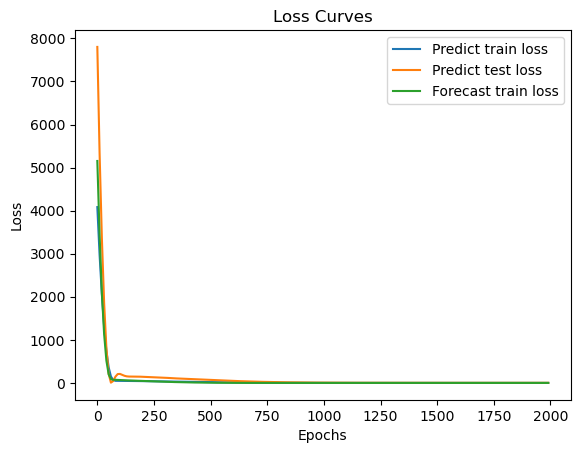

In [32]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(predict_train_loss_values).numpy()), label="Predict train loss")
plt.plot(epoch_count, predict_test_loss_values, label="Predict test loss")

plt.plot(epoch_count, np.array(torch.tensor(forecast_train_loss_values).numpy()), label="Forecast train loss")

plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();